# IS424: Data Mining & Biz Analytics
## Team: G3T3
### Project: Predicting Loan Default based on Customer Profile
### AdaBoost
---

# 1. Setting up the notebook

### Import libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from category_encoders import TargetEncoder

from sklearn.preprocessing import MinMaxScaler

from sklearn.decomposition import PCA
from sklearn.feature_selection import chi2

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, fbeta_score, accuracy_score, roc_auc_score

### Import dataset

In [2]:
df = pd.read_csv("../dataset/loanprediction.csv")
df.drop("Id", axis=1, inplace=True)
df.columns = ["income", "age", "experience", "marital_status", "house_ownership", "car_ownership", "profession", "city", "state", "current_job_years", "current_house_years", "risk_flag"]
numerical_cols = ["income", "age", "experience", "current_job_years", "current_house_years"]

### Splitting the data into train and test splits

In [3]:
x = df.drop("risk_flag", axis=1)
y = df["risk_flag"]

In [4]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, stratify = y, random_state = 2021)

# 2. Data Preprocessing

In [5]:
def data_preprocessing(df_x, df_y):
    
    # Label encoding categorical columns with 2 types of categories
    x = df_x.copy()
    label_enc = LabelEncoder()
    x["marital_status"] = label_enc.fit_transform(x["marital_status"])
    x["car_ownership"] = label_enc.fit_transform(x["car_ownership"])
    
    # One Hot Encoding house_ownership column & Combining back to dataframe
    onehot_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
    
    house_ownership_values = onehot_encoder.fit_transform( x[['house_ownership']] )
    house_ownership_labels = np.array(["norent_noown", "owned", "rented"]).ravel()
    house_ownership_df = pd.DataFrame(house_ownership_values, columns=house_ownership_labels)

    x.reset_index(drop=True, inplace=True)
    house_ownership_df.reset_index(drop=True, inplace=True)
    x = pd.concat([ x, house_ownership_df], axis=1)
    
    x.drop("house_ownership", axis=1, inplace=True)
    
    # Target Encoding the high cardinality categorical columns: profession, city, state
    # https://medium.com/analytics-vidhya/target-encoding-vs-one-hot-encoding-with-simple-examples-276a7e7b3e64
    profession_target_enc = TargetEncoder()
    x["profession_encoded"] = profession_target_enc.fit_transform(x["profession"], df_y)
    city_target_enc = TargetEncoder()
    x["city_encoded"] = city_target_enc.fit_transform(x["city"], df_y)
    state_target_enc = TargetEncoder()
    x["state_encoded"] = state_target_enc.fit_transform(x["state"], df_y)
    x.drop("profession", axis=1, inplace=True)
    x.drop("city", axis=1, inplace=True)
    x.drop("state", axis=1, inplace=True)
    
    # https://stackoverflow.com/questions/51237635/difference-between-standard-scaler-and-minmaxscaler
    # https://www.geeksforgeeks.org/standardscaler-minmaxscaler-and-robustscaler-techniques-ml/
    min_max_scaler = MinMaxScaler()
    x[numerical_cols] = min_max_scaler.fit_transform(x[numerical_cols])
    # need to scale the encoded columns?
    
    return x

In [6]:
x_train = data_preprocessing(x_train, y_train)
x_test = data_preprocessing(x_test, y_test)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [7]:
x_train

,income,age,experience,marital_status,car_ownership,current_job_years,current_house_years,norent_noown,owned,rented,profession_encoded,city_encoded,state_encoded
0,0.327124,0.603448,1.00,1,0,0.428571,0.50,0.0,0.0,1.0,0.113368,0.110749,0.108586
1,0.130675,0.551724,0.20,1,0,0.285714,1.00,0.0,0.0,1.0,0.099455,0.094099,0.105572
2,0.501596,0.448276,1.00,1,0,0.500000,0.00,0.0,0.0,1.0,0.112555,0.101322,0.108927
3,0.281679,0.568966,0.00,1,0,0.000000,0.00,0.0,0.0,1.0,0.105653,0.140426,0.107906
4,0.878926,0.344828,0.10,1,0,0.142857,0.25,0.0,0.0,1.0,0.119820,0.116635,0.105572
...,...,...,...,...,...,...,...,...,...,...,...,...,...
201595,0.956922,0.517241,0.65,1,0,0.857143,0.75,0.0,0.0,1.0,0.115659,0.085878,0.109657
201596,0.699145,0.948276,0.90,1,1,0.428571,1.00,0.0,0.0,1.0,0.114032,0.073286,0.103861
201597,0.945682,0.293103,0.60,1,0,0.642857,1.00,0.0,0.0,1.0,0.111579,0.115059,0.101977
201598,0.043618,0.793103,0.95,1,0,0.785714,0.75,0.0,0.0,1.0,0.113309,0.109873,0.108586


# 3. Model Train

In [7]:
def run_variation_model(x_train, y_train, x_test, y_test, variation):
    if "pca" in variation:
        pca = PCA(0.9, random_state=2021)
        x_train = pca.fit_transform(x_train)
        x_test = pca.fit_transform(x_test)
        
    if "chi_square" in variation:
        chi_scores = chi2(x_train, y_train)
        p_values = pd.Series(chi_scores[1], index = x_train.columns)
        p_values.sort_values(ascending = False , inplace = True)
        p_values.plot.bar()
        x_train = x_train.drop(["profession_encoded", "state_encoded", "city_encoded", "income"], axis=1)
        x_test = x_test.drop(["profession_encoded", "state_encoded", "city_encoded", "income"], axis=1)
        
    if "smote" in variation:
        oversampler = SMOTE(random_state=2021)
        x_train, y_train = oversampler.fit_resample(x_train, y_train)
    
    adb_clf = AdaBoostClassifier(random_state=2021)
    adb_clf.fit(x_train, y_train)
    y_pred = adb_clf.predict(x_test)
    
    print(f"-------------------------TEST SCORES for {variation}-----------------------")
    print(f"Recall: {recall_score(y_test, y_pred)}")
    print(f"Precision: {precision_score(y_test, y_pred)}")
    print(f"F2-Score: {fbeta_score(y_test, y_pred, beta=2)}")
    print(f"Accuracy score: {accuracy_score(y_test, y_pred)}")
    print(f"AUC Score: {roc_auc_score(y_test, y_pred)}")
    print()

-------------------------TEST SCORES for base-----------------------
Recall: 0.0014518470721084046
Precision: 0.9
F2-Score: 0.00181407723937757
Accuracy score: 0.8771626984126984
AUC Score: 0.5007146115747864

-------------------------TEST SCORES for smote-----------------------
Recall: 0.20035489595095984
Precision: 0.14029142663503896
F2-Score: 0.18455228981544775
Accuracy score: 0.7506349206349207
AUC Score: 0.5140821107659145

-------------------------TEST SCORES for chi_square-----------------------
Recall: 0.0
Precision: 0.0
F2-Score: 0.0
Accuracy score: 0.8770039682539682
AUC Score: 0.5



/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


-------------------------TEST SCORES for pca-----------------------
Recall: 0.01597031779319245
Precision: 0.23185011709601874
F2-Score: 0.019624945486262535
Accuracy score: 0.8724603174603175
AUC Score: 0.5042748356007432

-------------------------TEST SCORES for smote, chi_square-----------------------
Recall: 0.5621874495886433
Precision: 0.14382402707275804
F2-Score: 0.3554164032063965
Accuracy score: 0.5345238095238095
AUC Score: 0.5464157763316172

-------------------------TEST SCORES for smote, pca-----------------------
Recall: 0.49007904500725924
Precision: 0.13644121081469504
F2-Score: 0.3227657133143512
Accuracy score: 0.5557738095238095
AUC Score: 0.5275331312455133



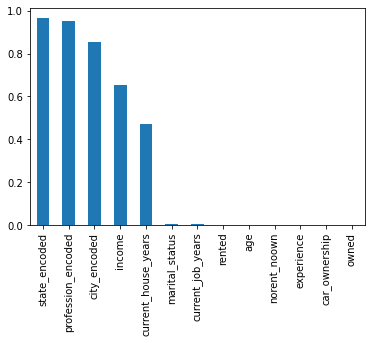

In [8]:
variations = ["base",
              "smote",
              "chi_square",
              "pca",
              "smote, chi_square",
              "smote, pca"]

for variation in variations:
    run_variation_model(x_train, y_train, x_test, y_test, variation)